# Inflation, Unemploymet and Real GDP

The goal of this project is to analyze the employment rates of men and women across various industries. We intend to present both the overall employment figures and highlight differences within specific sectors. Our objective is to identify sectors where one gender is predominant over the other and vice versa. Additionally, we aim to examine employment growth rates over time and assess how external factors, such as the 2020 pandemic, have impacted workforce dynamics. Through this analysis, we seek to gain insights into gender representation in the labor market and understand the effects of external events on employment trends.

Imports and load of relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import datetime
import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject as dp

#If you dont have the content below, remove the hashtag and install them

# pip install pandas-datareader
# %pip install git+https://github.com/alemartinello/dstapi
# %pip install pandas-datareader

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## Importing inflation data from Denmark Statistics

We consider the following dictionary definitions wrt. table PRIS111

In [2]:
columns_dict = {}
columns_dict['VAREGR'] = 'variable'
columns_dict['ENHED'] = 'unit'
columns_dict['TID'] = 'Year'
columns_dict['INDHOLD'] = 'Inflation rate'

var_dict = {} # var is for variable
var_dict['00 Consumer price index, total'] = 'Y'


unit_dict = {}
unit_dict['Index'] = 'Indexnumber'
unit_dict['Percentage change compared to previous month (per cent)'] = 'pct month'
unit_dict['Percentage change compared to same month the year before (per cent)'] = 'pct year'

In [3]:
# Importing inflation data via Api.  
PRIS111_api = DstApi('PRIS111') 
params = PRIS111_api._define_base_params(language='en')

PRIS111 = PRIS111_api.get_data(params)

In [4]:
# Renaming columns of the DataFrame PRIS111. 
PRIS111.rename(columns=columns_dict,inplace=True)

# Looping over the var dictionary.
for key,value in var_dict.items():
    PRIS111.variable.replace(key,value,inplace=True)

# Looping over the unit dictionary.
for key,value in unit_dict.items():
    PRIS111.unit.replace(key,value,inplace=True)


In [5]:
# Only keep rows where the variable is in `[Y]`. Afterwards convert the `value` column to a float.

# Ensuring 'year' is a string before applying string methods
PRIS111['Year'] = PRIS111['Year'].astype(str)

# Filter based on 'variable' values
var_vals = var_dict.values()
I_var = PRIS111['variable'].isin(var_vals)
PRIS111 = PRIS111[I_var]

# Grouping variables
# PRIS111.groupby(['variable','unit']).describe()

## Exploring data set

In [6]:
# Ensuring 'year' is a string before applying string methods
PRIS111['Year'] = PRIS111['Year'].astype(str)

# Filter based on 'variable' values
var_vals = var_dict.values()
I_var = PRIS111['variable'].isin(var_vals)
PRIS111 = PRIS111[I_var]

# Remove rows where 'unit' is either "Indexnumber" or "pct month"
units_to_exclude = ['Indexnumber', 'pct month']
I_unit = ~PRIS111['unit'].isin(units_to_exclude)
PRIS111 = PRIS111[I_unit]

# Filter to keep only rows where 'year' ends with "M12", then remove the "M12" part
I_year_suffix = PRIS111['Year'].str.endswith("M12")
PRIS111 = PRIS111[I_year_suffix]
PRIS111['Year'] = PRIS111['Year'].str.replace('M12', '')

# Convert 'year' back to integer for proper comparison and sorting
PRIS111['Year'] = PRIS111['Year'].astype(int)

# Exclude rows before "2007" and the year "2023"
PRIS111 = PRIS111[(PRIS111['Year'] >= 2007) & (PRIS111['Year'] != 2023)]

# Sort the DataFrame by 'year' in ascending order
PRIS111 = PRIS111.sort_values(by='Year')

# PRIS111


## Merge inflation- and unemployment data from Denmark Statistics

We merge with AULP01: Unemployment

In [7]:
FT_api = DstApi('AULP01')
params = FT_api._define_base_params(language='en')
params['variables'][0]['values'] = ['000']
params['variables'][1]['values'] = ['TOT']
params['variables'][2]['values'] = ['TOT']
params['variables'][3]['values'] = ['2007','2008','2009','2010','2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
## 000 is the code for all of Denmark, this can be seen by using: FT_api.variable_levels('HOVEDDELE', language='en')
unemp = FT_api.get_data(params=params)

unemp.rename(columns={'TID':'Year','INDHOLD':'Unemployment'},inplace=True)
unemp =  unemp.loc[:,['Year','Unemployment']]

In [8]:
# hint, merged = pd.merge(?,?,how='?',on=[?])
# merged_true.tail(10)

# Merge the DataFrames
#merged = pd.merge(PRIS111, unemp, how='left', on=['year'])

# Display the tail of the new DataFrame
# merged.tail(20)

# We merge our two dataframes inflation (PRIS111) and Unemployment (unemp)
merged = pd.merge(PRIS111, unemp, how='left', on='Year')

Combined_data = merged[['Year', 'Inflation rate', 'Unemployment']]

In [9]:
Combined_data.head(2)

,Year,Inflation rate,Unemployment
0,2007,2.3,3.6
1,2008,2.4,2.6


## Real GDP for Denmark

In [10]:
# Importing data from CSV file 'Real GDP'
GDP = pd.read_csv('GDP new1.csv',delimiter=';')

## Display the data set

In [11]:
#Here we display the data to see the values for Real GDP
GDP.head(10)

,Year,Real GDP
0,2007,1879.0
1,2008,1869.4
2,2009,1777.7
3,2010,1810.9
4,2011,1835.1
5,2012,1839.3
6,2013,1856.5
7,2014,1886.5
8,2015,1930.7
9,2016,1993.4


In [12]:
# We display our combined data for the inflation- and unemployment rate. 
Combined_data.head(2)

,Year,Inflation rate,Unemployment
0,2007,2.3,3.6
1,2008,2.4,2.6


We combine all three dataframes Real GDP with inflation rate and unemployment rate

In [13]:
# We join/ merge our dataframe real GDP with our combined data which contains dataframe inflation- and unemployment rate. 
merging = pd.merge(GDP, Combined_data, how='left', on=['Year'])

Combined_data1 = merging[["Year", "Inflation rate", "Unemployment", "Real GDP"]]
Combined_data1.head(5)

,Year,Inflation rate,Unemployment,Real GDP
0,2007,2.3,3.6,1879.0
1,2008,2.4,2.6,1869.4
2,2009,1.4,4.8,1777.7
3,2010,2.8,6.1,1810.9
4,2011,2.4,6.0,1835.1


In [14]:
# We convert 'Year' column to integer if it's stored as string. 
Combined_data1['Year'] = pd.to_numeric(Combined_data1['Year'], errors='coerce')
# Here we do the same. Converting 'Real GDP', 'Inflation rate' and 'Unemployment' to a numeric type. 
Combined_data1['Real GDP'] = pd.to_numeric(Combined_data1['Real GDP'], errors='coerce')
Combined_data1['Inflation rate'] = pd.to_numeric(Combined_data1['Inflation rate'], errors='coerce')
Combined_data1['Unemployment'] = pd.to_numeric(Combined_data1['Unemployment'], errors='coerce')


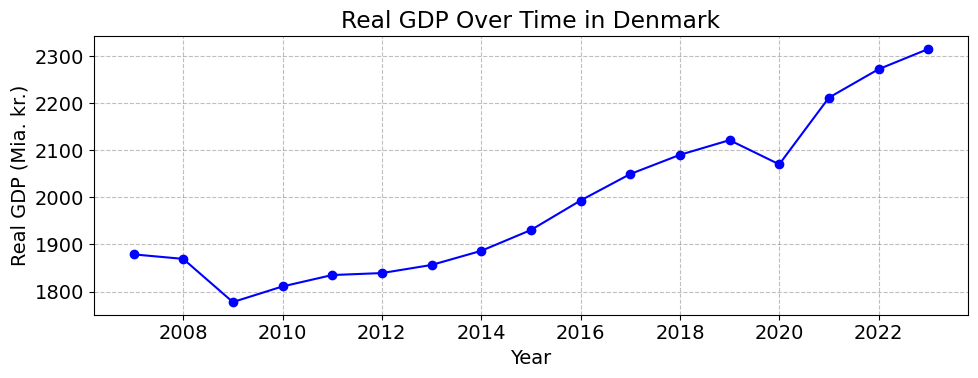

In [29]:
# We sort our dataframe 'Combined data' by the 'Year' column
Combined_data1.sort_values(by='Year', inplace=True)

# Plotting the graph for Real GDP
plt.figure(figsize=(10, 4))
plt.plot(GDP['Year'], GDP['Real GDP'], marker='o', color='blue')
plt.ylabel('Real GDP (Mia. kr.)')
plt.title('Real GDP Over Time in Denmark')
plt.xlabel('Year')
plt.grid(True)  # Add gridlines
plt.tight_layout()
plt.show()

The graph above shows the development of GDP from 2007 to 2023. In the graph, we can divide it into the following sub-periods. From 2007 to 2009, there is a significant decline, which is due to the financial crisis. GDP decreases by 100 billions DKK. Next, there is a trend of a significant increase in GDP from 2009 to 2019. GDP increases by 344 billions DKK. From 2019 to 2020, there is a slight decrease in GDP due to COVID-19 and decreases by 51.4 billions DKK. The curve is increasing again from 2020 onwards until 2023.

## Analyzing the data

In [16]:
# We calculate average Unemployment Rate
average_unemp = Combined_data1['Unemployment'].mean()

# Doing the same. Calculate average Inflation Rate
average_inf = Combined_data1['Inflation rate'].mean()

# Printing the results making sure it only prints 2 decimals.  
print("Average Unemployment Rate:", round(average_unemp,2))
print("Average Inflation Rate:", round(average_inf,2))



Average Unemployment Rate: 4.43
Average Inflation Rate: 1.89


Here we see that the average unemployment rate and the inflation rate for the period 2007-2022 are 4.43 pct. and 1.89 pct.

In [22]:
#Calculating the correlation between Real GDP and Inflation
corr_GDP_inf = Combined_data1['Real GDP'].corr(Combined_data1['Inflation rate'])
print("Correlation between GDP and Inflation Rate:", round(corr_GDP_inf,2))

Correlation between GDP and Inflation Rate: 0.41


The data shows a positive correlation between real GDP and the inflation rate. According to the Phillips curve, inflation rises as demand for labor increases. In this scenario, workers can demand higher wages, resulting in higher production prices. This, in turn, leads to an increase in capital and labor, resulting in a higher real GDP.

In [23]:
#Calculate the correlation between Real GDP and unemployment rates.

corr_GDP_unemp = Combined_data1['Unemployment'].corr(Combined_data1['Real GDP'])

# Print the correlation coefficient
print("Correlation coefficient between Real GDP and Unemployment:", round(corr_GDP_unemp,2))

Correlation coefficient between Real GDP and Unemployment: -0.65


We see a positive correlation between Real GDP and Unemployment. As Real GDP increases, Unemployment tends to decrease, and vice versa. Due the Phillips curve there is an inverse relationship between inflation and unemployment in the short run. When the economy is performing well and Real GDP is increasing, there tends to be higher demand for goods and services, leading to increased production and employment opportunities. As more people find jobs, the unemployment rate decreases. Conversely, during economic downturns, Real GDP decreases, leading to lower demand for goods and services and, consequently, higher unemployment rates. 

In [24]:
# Calculate the correlation between inflation rates and unemployment rates
corr_inf_unemp = Combined_data1['Inflation rate'].corr(Combined_data1['Unemployment'])

# Print the correlation coefficient
print("Correlation coefficient between Inflation rate and Unemployment rate:", round(corr_inf_unemp,2))

Correlation coefficient between Inflation rate and Unemployment rate: -0.39


A negative correlation between inflation and unemployment is observed to be -0.39. As described above, according to the Phillips curve, high inflation will lead to low unemployment. This is attributed to several factors, but the primary explanation lies in the increased demand for labor in the labor market. More individuals are employed, and as a result, businesses can offer higher wages to employees, resulting in low unemployment. It should be noted that there are multiple factors at play. This is a simplified version/explanation.

In [28]:
# Calculate the annual growth rate of GDP (percentage change in GDP)
GDP['GDP_growth'] = GDP['Real GDP'].pct_change() * 100 

# Create a new DataFrame with Year and GDP Growth Rate
GDP_growth_ = pd.DataFrame({'Year': GDP['Year'], 'GDP_growth': GDP['GDP_growth']})

# Drop the first row, 2007, since it will have NaN value for growth rate
GDP_growth_ = GDP_growth_.dropna()

# Print the DataFrame with Year and GDP Growth Rate
print(round(GDP_growth_,2))

    Year  GDP_growth
1   2008       -0.51
2   2009       -4.91
3   2010        1.87
4   2011        1.34
5   2012        0.23
6   2013        0.94
7   2014        1.62
8   2015        2.34
9   2016        3.25
10  2017        2.82
11  2018        1.99
12  2019        1.49
13  2020       -2.42
14  2021        6.84
15  2022        2.73
16  2023        1.89


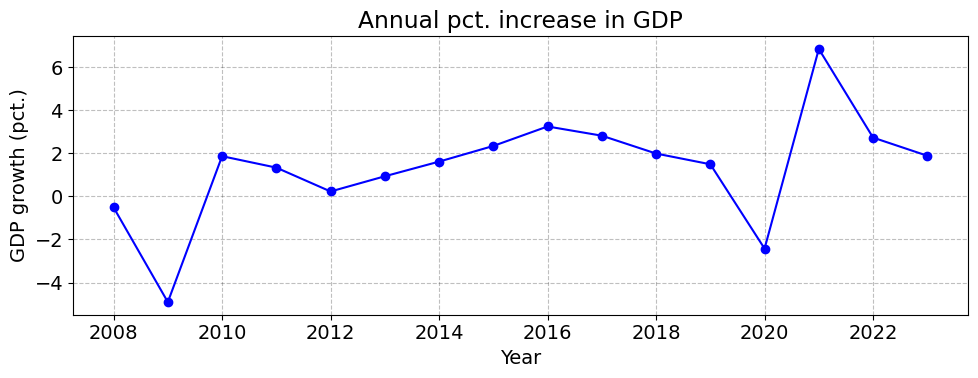

In [21]:
GDP_growth_.sort_values(by='Year', inplace=True)

# Plotting the graph for annual pct. increas in GDP
plt.figure(figsize=(10, 4))
plt.plot(GDP_growth_['Year'], GDP_growth_['GDP_growth'], marker='o', color='blue')
plt.ylabel('GDP growth (pct.)')
plt.title('Annual pct. increase in GDP')
plt.xlabel('Year')
plt.grid(True)  # Add gridlines
plt.tight_layout()
plt.show()

The graph shows the annual percentage increase in GDP. The curve shows significant volatility throughout the period from 2008 to 2023. As previously explained in the figure illustrating Real GDP over time in Denmark, we can highlight 2009, 2020, and 2022. In 2009, a sharp decline of 4.91 percent is observed, attributed to Denmark being hit by the financial crisis. This had serious consequences on the Danish economy, including GDP. From 2009 to 2010, there is an increase of 1.87 percent, which begins to stabilize the economy. In 2020, COVID-19 hits again, impacting the economy and GDP. However, we quickly bring the economy back to a relatively stable level, and in 2021, we see an increase of 6.84 percent. This is the highest increase observed on the graph so far. In 2022, the war in Ukraine begins, affecting several countries due to the high energy and gas prices.